In [1]:
import pandas as pd
from sklearn import model_selection, svm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
from sklearn.feature_extraction.text import CountVectorizer

import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# Data Read

In [2]:

df=pd.read_csv("C:/Users/rasib/Downloads/archive/twitter_racism_parsed_dataset.csv")


In [3]:
df.head()

,index,id,Text,Annotation,oh_label
0,5.767493e+17,5.767493e+17,@AAlwuhaib1977 Muslim mob violence against Hin...,racism,1
1,5.408905e+17,5.408905e+17,@Te4m_NiGhtM4Re http://t.co/5Ih7MkDbQG,none,0
2,5.678433e+17,5.678433e+17,@jncatron @isra_jourisra @AMPalestine Islamoph...,racism,1
3,5.766462e+17,5.766462e+17,"Finally I'm all caught up, and that sudden dea...",none,0
4,5.713492e+17,5.713492e+17,@carolinesinders @herecomesfran *hugs*,none,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13471 entries, 0 to 13470
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   index       13471 non-null  float64
 1   id          13471 non-null  float64
 2   Text        13471 non-null  object 
 3   Annotation  13471 non-null  object 
 4   oh_label    13471 non-null  int64  
dtypes: float64(2), int64(1), object(2)
memory usage: 526.3+ KB


In [5]:
df.describe()

,index,id,oh_label
count,1.347100e+04,1.347100e+04,13471.00000
mean,5.645450e+17,5.645450e+17,0.14624
std,2.263979e+16,2.263979e+16,0.35336
min,3.208178e+17,3.208178e+17,0.00000
25%,5.637581e+17,5.637581e+17,0.00000
50%,5.714068e+17,5.714068e+17,0.00000
75%,5.755013e+17,5.755013e+17,0.00000
max,5.922733e+17,5.922733e+17,1.00000


# Data Analysis

In [6]:
df.Annotation.unique()

array(['racism', 'none'], dtype=object)

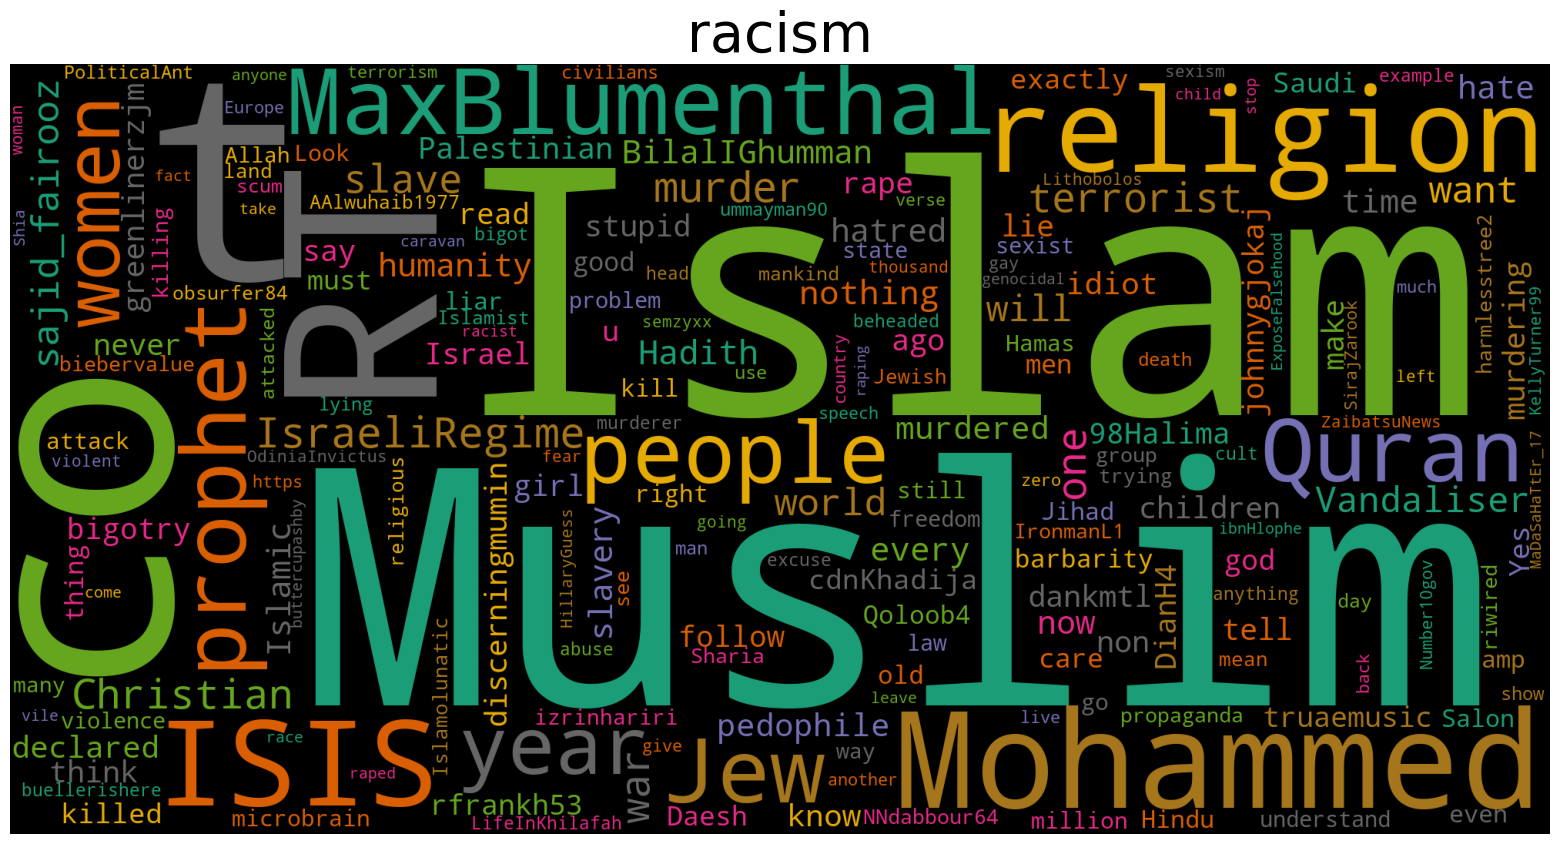

In [7]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
subset1 = df[df['Annotation']=='racism']
text_race = subset1.Text.values
cloud1=WordCloud(background_color='black',colormap="Dark2",collocations=False,width=2000,height=1000).generate(" ".join(text_race))

plt.axis('off')
plt.title("racism",fontsize=40)
plt.imshow(cloud1)

In [8]:
def get_top_n_gram(corpus,ngram_range,n=None):
    vec = CountVectorizer(ngram_range=ngram_range,stop_words = STOPWORDS).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [9]:
from wordcloud import STOPWORDS

In [10]:
unigrams = get_top_n_gram(text_race,(1,1),10)
bigrams = get_top_n_gram(text_race,(2,2),10)

Race_1 = pd.DataFrame(unigrams, columns = ['Text' , 'count'])
Race_1.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='black', title='Top 10 Unigrams',orientation='h')

Race_2 = pd.DataFrame(bigrams, columns = ['Text' , 'count'])
Race_2.groupby('Text').sum()['count'].sort_values(ascending=True).iplot(
    kind='bar', yTitle='Count', linecolor='black',color='black', title='Top 10 Bigrams',orientation='h')

# Data Preprocess

In [11]:
def removeSpecialCharacter(v):
    c = "".join([r for r in v if ('A' <= r <= 'Z') or ('a' <= r <= 'z') or (r == " ")])
    return c

df['Text']= df['Text'].apply(lambda x: removeSpecialCharacter (str(x)))
df['Text'].replace('', np.nan, inplace=True)

df.dropna(subset=['Text'], inplace=True)

In [12]:
# Dropping any duplicated comment
df = df.drop_duplicates(subset='Text', keep='first')
#df[:] = np.nan_to_num(df)

x=df["Text"]
y=df["oh_label"]

#split the text
df["Text"].str.split()

0        [AAlwuhaib, Muslim, mob, violence, against, Hi...
1                           [TemNiGhtMRe, httptcoIhMkDbQG]
2        [jncatron, israjourisra, AMPalestine, Islamoph...
3        [Finally, Im, all, caught, up, and, that, sudd...
4                   [carolinesinders, herecomesfran, hugs]
                               ...                        
13466    [mkr, NOOOOO, I, wanted, Kat, and, Andre, to, ...
13467    [RT, MumtazCeltik, WhiteHouse, VP, Kobane, JeS...
13468    [Glad, the, proper, competition, is, starting,...
13469    [No, worries, Pete, and, Manu, take, all, the,...
13470    [mykitchenrules, mkr, please, kick, off, that,...
Name: Text, Length: 13460, dtype: object

In [13]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(x,y,test_size=0.20)
vectorizer = TfidfVectorizer(lowercase=False, use_idf=True)
vectTrain = vectorizer.fit_transform(X_train)
vectTest = vectorizer.transform(X_test)

In [14]:
train=vectTrain.toarray()
test=vectTest.toarray()

In [15]:
# Fitting Naive Bayes to the Training set  
from sklearn.naive_bayes import GaussianNB  
classifier = GaussianNB()  
classifier.fit(train, Y_train)

GaussianNB()

In [16]:

#predicting the test data labels
predictions = classifier.predict(test)
#getting the acuuracy score
print("Naive Bayes accuracy score: ", accuracy_score(predictions, Y_test)*100)

Naive Bayes accuracy score:  82.57800891530461


# Confusion matrix


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve,classification_report,confusion_matrix,plot_confusion_matrix
cf=confusion_matrix(predictions, Y_test)

<AxesSubplot:>

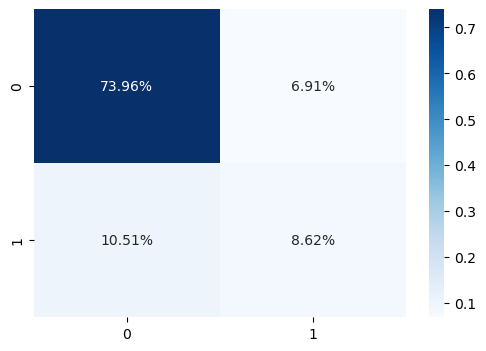

In [18]:
#cf=confusion_matrix(predictions, Y_test)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

# Classification report

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification report")
print(classification_report(predictions, Y_test))

Classification report
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      2177
           1       0.56      0.45      0.50       515

    accuracy                           0.83      2692
   macro avg       0.72      0.68      0.70      2692
weighted avg       0.81      0.83      0.82      2692



## Hyperparameter Tuning to improve Accuracy
Var_smoothing (Variance smoothing) parameter specifies the portion of the largest variance of all features to be added to variances for stability of calculation.

Gaussian Naive Bayes assumes that features follows normal distribution which is most unlikely in real world.So solve this problem we can perform "power transformation" on each feature to make it more or less normally distributed. By default, PowerTransformer results in features that have a 0 mean and 1 standard deviation.

In [20]:
# Gaussian Naive Bayes Classification
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
import scipy.stats as stats

In [21]:
from sklearn.model_selection import RepeatedStratifiedKFold

cv_method = RepeatedStratifiedKFold(n_splits=5, 
                                    n_repeats=3, 
                                    random_state=999)

In [22]:
from sklearn.preprocessing import PowerTransformer
params_NB = {'var_smoothing': np.logspace(0,-9, num=10)}

gs_NB = GridSearchCV(estimator=classifier, 
                     param_grid=params_NB, 
                     cv=cv_method,
                     verbose=1, 
                     scoring='accuracy')

Data_transformed = PowerTransformer().fit_transform(test)

gs_NB.fit(Data_transformed, Y_test);

Fitting 15 folds for each of 10 candidates, totalling 150 fits


In [23]:
gs_NB.best_score_

0.8031213431638285

In [24]:
results_NB = pd.DataFrame(gs_NB.cv_results_['params'])
results_NB['test_score'] = gs_NB.cv_results_['mean_test_score']

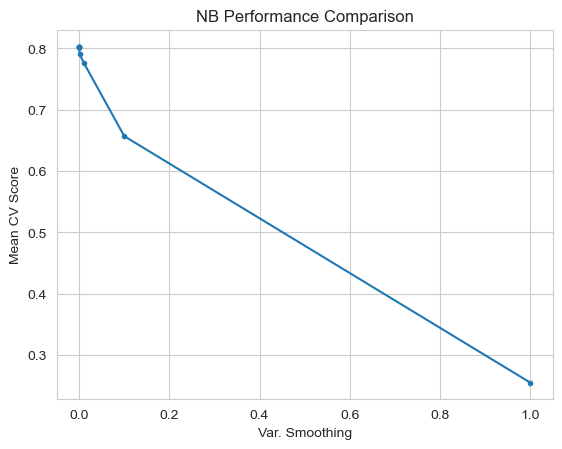

In [25]:
plt.plot(results_NB['var_smoothing'], results_NB['test_score'], marker = '.')    
plt.xlabel('Var. Smoothing')
plt.ylabel("Mean CV Score")
plt.title("NB Performance Comparison")
plt.show()

#  Random Forest

In [26]:
from sklearn.ensemble import RandomForestClassifier  
classifier= RandomForestClassifier(n_estimators= 10, criterion="entropy")  
classifier.fit(train, Y_train)  

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [27]:

#predicting the test data labels
predictions = classifier.predict(test)
#getting the acuuracy score
print("Random Forest accuracy score: ", accuracy_score(predictions, Y_test)*100)

Random Forest accuracy score:  89.41307578008916


confusion matrix


<AxesSubplot:>

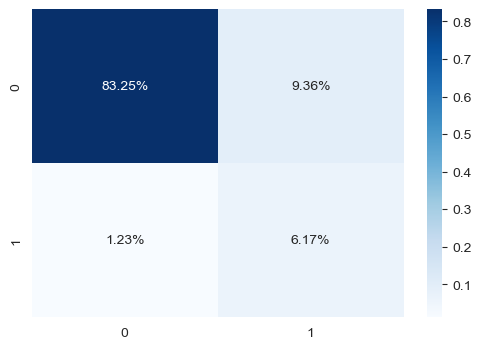

In [28]:
# confusion matrix
print("confusion matrix")
cf=confusion_matrix(predictions, Y_test)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [29]:
print("Classification report")
print(classification_report(predictions, Y_test))

Classification report
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      2493
           1       0.40      0.83      0.54       199

    accuracy                           0.89      2692
   macro avg       0.69      0.87      0.74      2692
weighted avg       0.94      0.89      0.91      2692



# XGBoost

In [30]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [31]:
import xgboost as xgb

xgb_cl = xgb.XGBClassifier()
xgb_cl.fit(train, Y_train)  

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [32]:

#predicting the test data labels
predictions = xgb_cl.predict(test)
#getting the acuuracy score
print("XGBoost accuracy score: ", accuracy_score(predictions, Y_test)*100)

XGBoost accuracy score:  92.16196136701336


confusion matrix


<AxesSubplot:>

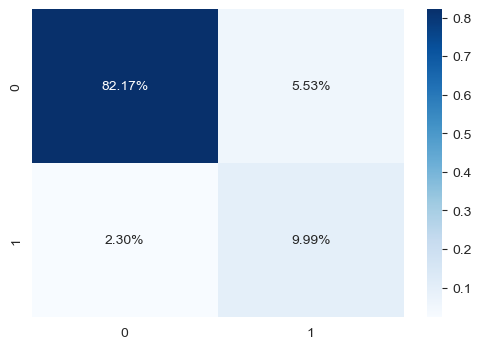

In [33]:
# confusion matrix
print("confusion matrix")
cf=confusion_matrix(predictions, Y_test)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [34]:
print("Classification report")
print(classification_report(predictions, Y_test))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      2361
           1       0.64      0.81      0.72       331

    accuracy                           0.92      2692
   macro avg       0.81      0.87      0.84      2692
weighted avg       0.93      0.92      0.93      2692



# SVM Support Vector Classification.

In [35]:
#importing library
from sklearn.svm import SVC
svc = SVC(random_state=42)
svc.fit(train, Y_train)

SVC(random_state=42)

In [36]:

#predicting the test data labels
predictions = svc.predict(test)
#getting the acuuracy score
print("SVM accuracy score: ", accuracy_score(predictions, Y_test)*100)

SVM accuracy score:  92.5705794947994


confusion matrix


<AxesSubplot:>

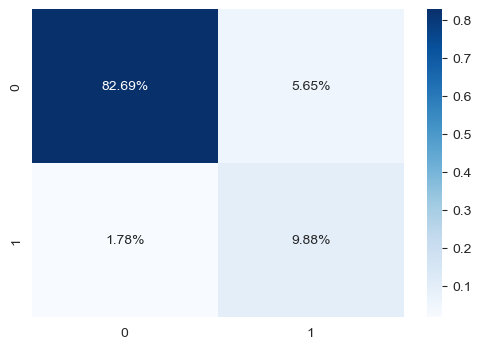

In [37]:
# confusion matrix
print("confusion matrix")
cf=confusion_matrix(predictions, Y_test)
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(6,4))
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues')

In [38]:
print("Classification report")
print(classification_report(predictions, Y_test))

Classification report
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      2378
           1       0.64      0.85      0.73       314

    accuracy                           0.93      2692
   macro avg       0.81      0.89      0.84      2692
weighted avg       0.94      0.93      0.93      2692

